In [14]:
# Import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict
from upsetplot import UpSet, from_memberships
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, mean_squared_error

In [16]:
df = pd.read_csv('../data/topic_probabilities_max.csv')

In [17]:
unique_values = df['vividness_bin'].unique()
print(unique_values)

column_names = df.columns.tolist()
print(column_names)

['0-3' '4-7' '8-10']
['id', 'What is your gender?', 'How old are you?', 'How would you describe your VISUAL imagery vividness on a scale from 0-10?', 'How long did you view the Ganzflicker?', 'Did you view the Ganzflicker with the lights in the room turned off?', 'Did you view the Ganzflicker on a computer or mobile phone?', 'How did you find the experience emotionally?', 'Did you see anything in the Ganzflicker? If not, confirm by answering "no" and then skip to the next section.', 'Please describe as much as you can remember about what you saw in the Ganzflicker:', 'About how long did it take before images started to emerge?', 'About how frequently did you experience images?', 'If you saw images, how intense were they?', 'If you saw images, how long did a single image last?', 'How did your normal state of consciousness change during the experience?', 'If you felt a change in your state of consciousness, please describe how you felt in more detail:', 'If you saw images, where did they

In [18]:
# Cleanup for the 27 topics

# Rename columns
df = df.rename(columns={
    'subject_id': 'participant_id',
    'What is your gender?': 'gender',
    'How old are you?': 'age',
    'How would you describe your VISUAL imagery vividness on a scale from 0-10?': 'visual_vividness',
    'How long did you view the Ganzflicker?': 'viewing_duration',
    'Did you view the Ganzflicker with the lights in the room turned off?': 'lights',
    'Did you view the Ganzflicker on a computer or mobile phone?': 'screen_type',
    'How did you find the experience emotionally?': 'emotion',
    'Did you see anything in the Ganzflicker? If not, confirm by answering "no" and then skip to the next section.': 'saw_hallucination',
    'Please describe as much as you can remember about what you saw in the Ganzflicker:': 'hallucination_description',
    'About how long did it take before images started to emerge?': 'hallucination_timing',
    'About how frequently did you experience images?': 'hallucination_frequency',
    'If you saw images, how intense were they?': 'hallucination_intensity',
    'If you saw images, how long did a single image last?': 'hallucination_duration',
    'How did your normal state of consciousness change during the experience?': 'consciousness_change',
    'If you felt a change in your state of consciousness, please describe how you felt in more detail:': 'consciousness_state',
    'If you saw images, where did they tend to appear on the screen?': 'hallucination_location',
    'Visual Patterns': 'visual_patterns',
    'Color flashes': 'color_flashes',
    'Morphing Faces': 'morphing_faces',
    'Geometric Shapes': 'geometric_shapes',
    'Stars and Galaxies': 'stars_galaxies',
    'Unpleasant experiences': 'unpleasant_experience',
    'Lines': 'lines',
    'Spirals and Rotation': 'spirals_and_rotation',
    'Spider web patterns': 'spider_web_patterns',
    'Tunnel': 'tunnels',
    'Fractals': 'fractals',
    'Auditory experiences': 'auditory_experiences',
    'Forest scenery': 'forest_scenery',
    'Visual perception': 'visual_perception',
    'Ball of Light': 'ball_of_light',
    'Duration of events': 'event_duration',
    'Perception limitations': 'perception_limitations',
    'City skyline': 'city_skyline',
    'Ocean at Night': 'ocean_at_night',
    'Nonsense Expressions': 'nonsense_expressions',
    'Rotating Flowers': 'rotating_flowers',
    'Butterfly Shapes': 'butterfly_shapes',
    'Space Travel': 'space_travel',
    'Moving Hallways': 'moving_hallways',
    'Eye perceptions': 'eye_perceptions',
    'Indifference': 'indifference',
    'Brief image clarity': 'brief_image_clarity'
})

df['vividness_bin'] = df['vividness_bin'].replace({
    '0-3': 'weak',
    '4-7': 'moderate',
    '8-10': 'strong'
})

In [19]:
df['vividness_bin_bicat'] = np.where(df['visual_vividness'].isin([0, 1, 2, 3]), 'aphantasia', 'imagery')

In [20]:
predictors = [
    'visual_patterns', 'color_flashes', 'morphing_faces', 'geometric_shapes', 'stars_galaxies',
    'unpleasant_experience', 'lines', 'spirals_and_rotation', 'spider_web_patterns', 'tunnels',
    'fractals', 'auditory_experiences', 'forest_scenery', 'visual_perception', 'ball_of_light',
    'event_duration', 'perception_limitations', 'city_skyline', 'ocean_at_night', 'nonsense_expressions',
    'rotating_flowers', 'butterfly_shapes', 'space_travel', 'moving_hallways', 'eye_perceptions',
    'indifference', 'brief_image_clarity'
]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


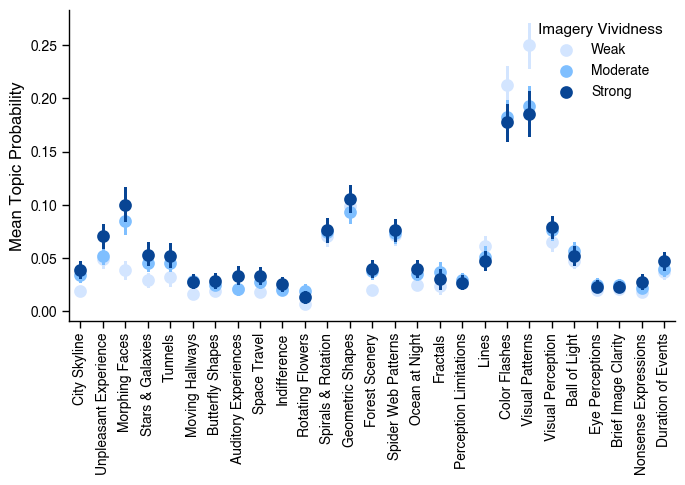

In [21]:
# ------------------------------------------------------------
# 0 · Imports & user-supplied objects
# ------------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Set Helvetica font
plt.rcParams['font.family'] = 'Helvetica'

# -- (A)  your DataFrame and predictor list -------------------
# df           : original DataFrame with topic-probability columns
# vividness_bin: categorical column with {'weak', 'moderate', 'strong'}
# predictors   : list of the 27 snake-case topic columns
# df_heat      : (optional) a heat-map DataFrame whose index gives
#                the display order we'd like on the x-axis
# ------------------------------------------------------------

# -- (B) pretty labels for the x-axis -------------------------
label_mapping = {
    "city_skyline":            "City Skyline",
    "unpleasant_experience":   "Unpleasant Experience",
    "morphing_faces":          "Morphing Faces",
    "stars_galaxies":          "Stars & Galaxies",
    "tunnels":                 "Tunnels",
    "moving_hallways":         "Moving Hallways",
    "butterfly_shapes":        "Butterfly Shapes",
    "auditory_experiences":    "Auditory Experiences",
    "space_travel":            "Space Travel",
    "indifference":            "Indifference",
    "rotating_flowers":        "Rotating Flowers",
    "spirals_and_rotation":    "Spirals & Rotation",
    "geometric_shapes":        "Geometric Shapes",
    "forest_scenery":          "Forest Scenery",
    "spider_web_patterns":     "Spider Web Patterns",
    "ocean_at_night":          "Ocean at Night",
    "fractals":                "Fractals",
    "perception_limitations":  "Perception Limitations",
    "lines":                   "Lines",
    "color_flashes":           "Color Flashes",
    "visual_patterns":         "Visual Patterns",
    "visual_perception":       "Visual Perception",
    "ball_of_light":           "Ball of Light",
    "eye_perceptions":         "Eye Perceptions",
    "brief_image_clarity":     "Brief Image Clarity",
    "nonsense_expressions":    "Nonsense Expressions",
    "event_duration":          "Duration of Events",
}

# ------------------------------------------------------------
# 1 · Assemble DataFrame for plotting
# ------------------------------------------------------------
df_scaled = pd.concat([df['vividness_bin'], df[predictors]], axis=1)

df_melted = df_scaled.melt(
    id_vars='vividness_bin',
    value_vars=predictors,
    var_name='Feature',
    value_name='Value'
)

# ------------------------------------------------------------
# 2 · Map pretty labels and drop any unmapped features
# ------------------------------------------------------------
df_melted['Feature'] = df_melted['Feature'].map(label_mapping)
df_melted = df_melted.dropna(subset=['Feature'])

# ------------------------------------------------------------
# 3 · Order x-axis using your heat-map (or alphabetical fallback)
# ------------------------------------------------------------
ordered_features = list(label_mapping.values()) 
df_melted['Feature'] = pd.Categorical(df_melted['Feature'], categories=ordered_features, ordered=True)

# ------------------------------------------------------------
# 4 · Plot with scientific paper formatting
# ------------------------------------------------------------
sns.set_context("paper", font_scale=1.2)
palette = {'weak': '#d3e5ff', 'moderate': '#7fbfff', 'strong': '#084594'}

# Create figure with 7-inch width (2-column scientific paper format)
plt.figure(figsize=(7, 5))
ax = sns.pointplot(
    data=df_melted,
    x='Feature',
    y='Value',
    hue='vividness_bin',
    dodge=0,
    errorbar=('ci', 95),
    capsize=0,
    err_kws={'linewidth': 0.8},
    palette=palette,
    join=False,
    markers='o',
    scale=1.3,
    markeredgewidth=0.1,
    markeredgecolor='white'
)

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Mean Topic Probability", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.tick_params(axis='y', labelsize=10)
sns.despine(top=True, right=True)

# Prettify legend with smaller, scientific paper appropriate styling
handles, labels = ax.get_legend_handles_labels()
pretty_labels = {'weak': 'Weak', 'moderate': 'Moderate', 'strong': 'Strong'}
ax.legend(
    handles=handles,
    labels=[pretty_labels[l] for l in labels],
    title="Imagery Vividness",
    fontsize=10,
    title_fontsize=11,
    frameon=False,
    loc='upper right'
)

plt.tight_layout()
# Save the plot in high resolution suitable for publication
plt.savefig('../plots//vividness_topic_probability.png', 
           dpi=300, 
           bbox_inches='tight', 
           facecolor='white',
           edgecolor='none')

# Save as PDF for vector graphics
plt.savefig('../plots//vividness_topic_probability.pdf', 
           bbox_inches='tight', 
           facecolor='white',
           edgecolor='none')
plt.show()

In [22]:
# Scale predictors

X = df[predictors].copy()
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=predictors)

In [23]:
def run_lasso_classifier(df, X, target_group):
    """
    Runs Lasso logistic regression for binary classification of a target imagery group.

    Parameters:
    - df: full DataFrame
    - X: feature matrix (DataFrame)
    - target_group: one of 'weak', 'moderate', 'strong'
    """

    y = df['vividness_bin'].apply(lambda x: 1 if x == target_group else 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    model = LogisticRegressionCV(
        Cs=np.logspace(-2, 2, 30),
        penalty='l1',
        solver='saga',
        scoring='f1',
        cv=10,
        max_iter=10000,
        random_state=42,
        class_weight='balanced',
    )

    model.fit(X_train, y_train)

    best_C = model.C_[0]
    best_lambda = 1 / best_C
    print(f"\nBest C (1/lambda): {best_C:.5f}")
    print(f"Equivalent lambda: {best_lambda:.5f}")

    y_pred = model.predict(X_test)
    print(f"\n===== LASSO Classifier for {target_group.upper()} vs all =====")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Non-zero coefficients
    coefs = pd.Series(model.coef_[0], index=X.columns)
    print("\nNon-zero Coefficients:\n", coefs[coefs != 0].sort_values(ascending=False))

    return model, coefs


In [24]:
df['vividness_bin'].value_counts()

weak_count = (df['vividness_bin'] == 'weak').sum()
non_weak_count = (df['vividness_bin'] != 'weak').sum()
moderate_count = (df['vividness_bin'] == 'moderate').sum()
non_moderate_count = (df['vividness_bin'] != 'moderate').sum()
strong_count = (df['vividness_bin'] == 'strong').sum()
non_strong_count = (df['vividness_bin'] != 'strong').sum()

print(f"Weak: {weak_count}, Non-weak: {non_weak_count}")
print(f"Moderate: {moderate_count}, Non-moderate: {non_moderate_count}")
print(f"Strong: {strong_count}, Non-strong: {non_strong_count}")


Weak: 1515, Non-weak: 2850
Moderate: 1634, Non-moderate: 2731
Strong: 1216, Non-strong: 3149


In [25]:
model_weak, coefs_weak = run_lasso_classifier(df, X, 'weak')
model_moderate, coefs_moderate = run_lasso_classifier(df, X, 'moderate')
model_strong, coefs_strong = run_lasso_classifier(df, X, 'strong')


Best C (1/lambda): 0.01374
Equivalent lambda: 72.78954

===== LASSO Classifier for WEAK vs all =====
              precision    recall  f1-score   support

           0       0.79      0.32      0.45       570
           1       0.40      0.84      0.54       303

    accuracy                           0.50       873
   macro avg       0.59      0.58      0.50       873
weighted avg       0.66      0.50      0.48       873

Confusion Matrix:
 [[180 390]
 [ 47 256]]

Non-zero Coefficients:
 visual_patterns      0.057602
color_flashes        0.018217
visual_perception   -0.002359
space_travel        -0.006981
rotating_flowers    -0.024749
moving_hallways     -0.029647
stars_galaxies      -0.055514
city_skyline        -0.080514
forest_scenery      -0.081623
morphing_faces      -0.164637
dtype: float64

Best C (1/lambda): 5.73615
Equivalent lambda: 0.17433

===== LASSO Classifier for MODERATE vs all =====
              precision    recall  f1-score   support

           0       0.65      

In [26]:
def lasso_table(coefs, group_name):
    df = coefs[coefs != 0].sort_values(ascending=False).reset_index()
    df.columns = ['feature', 'coefficient']
    df['imagery_bin'] = group_name
    return df

lasso_results = {
    'weak': lasso_table(coefs_weak, 'weak'),
    'moderate': lasso_table(coefs_moderate, 'moderate'),
    'strong': lasso_table(coefs_strong, 'strong'),
}


from IPython.display import display

for group, df_coeffs in lasso_results.items():
    print(f"\n===== Lasso Coefficients for {group.upper()} Imagery =====")
    display(df_coeffs)



===== Lasso Coefficients for WEAK Imagery =====


,feature,coefficient,imagery_bin
0,visual_patterns,0.057602,weak
1,color_flashes,0.018217,weak
2,visual_perception,-0.002359,weak
3,space_travel,-0.006981,weak
4,rotating_flowers,-0.024749,weak
5,moving_hallways,-0.029647,weak
6,stars_galaxies,-0.055514,weak
7,city_skyline,-0.080514,weak
8,forest_scenery,-0.081623,weak
9,morphing_faces,-0.164637,weak



===== Lasso Coefficients for MODERATE Imagery =====


,feature,coefficient,imagery_bin
0,morphing_faces,0.083629,moderate
1,fractals,0.083118,moderate
2,forest_scenery,0.081868,moderate
3,rotating_flowers,0.079437,moderate
4,moving_hallways,0.069907,moderate
5,ball_of_light,0.058772,moderate
6,eye_perceptions,0.046981,moderate
7,visual_perception,0.036345,moderate
8,ocean_at_night,0.034182,moderate
9,stars_galaxies,0.029721,moderate



===== Lasso Coefficients for STRONG Imagery =====


,feature,coefficient,imagery_bin
0,city_skyline,0.093568,strong
1,unpleasant_experience,0.092476,strong
2,morphing_faces,0.089577,strong
3,stars_galaxies,0.060767,strong
4,tunnels,0.059815,strong
5,butterfly_shapes,0.059586,strong
6,auditory_experiences,0.043454,strong
7,nonsense_expressions,0.042380,strong
8,space_travel,0.034291,strong
9,indifference,0.012493,strong


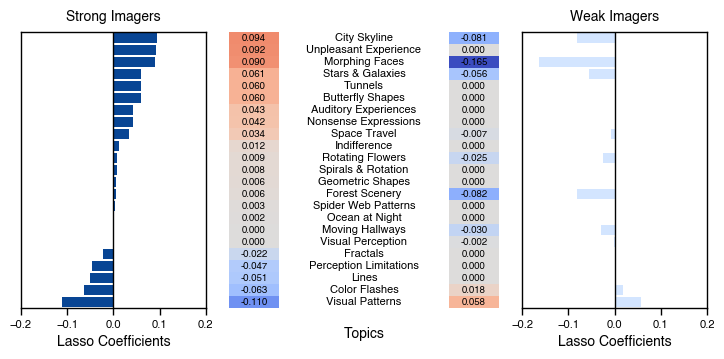

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import os

# Set Helvetica font
plt.rcParams['font.family'] = 'Helvetica'

# Include ALL features that have non-zero coefficients in ANY model
all_features = sorted(set(coefs_weak.index) | set(coefs_strong.index))

df_combined = pd.DataFrame(index=all_features, columns=['weak', 'strong'])
df_combined['weak'] = 0.0
df_combined['strong'] = 0.0

# Fill in the actual coefficient values
for feature in coefs_weak.index:
    if feature in df_combined.index:
        df_combined.loc[feature, 'weak'] = coefs_weak[feature]

for feature in coefs_strong.index:
    if feature in df_combined.index:
        df_combined.loc[feature, 'strong'] = coefs_strong[feature]

# Keep ALL features - don't filter out any rows
# But filter out rows where BOTH weak and strong are zero
df_combined = df_combined[(df_combined['weak'] != 0) | (df_combined['strong'] != 0)]

# Apply label mapping
label_mapping = {
    "city_skyline": "City Skyline",
    "unpleasant_experience": "Unpleasant Experience",
    "morphing_faces": "Morphing Faces",
    "stars_galaxies": "Stars & Galaxies",
    "tunnels": "Tunnels",
    "moving_hallways": "Moving Hallways",
    "butterfly_shapes": "Butterfly Shapes",
    "auditory_experiences": "Auditory Experiences",
    "space_travel": "Space Travel",
    "indifference": "Indifference",
    "rotating_flowers": "Rotating Flowers",
    "spirals_and_rotation": "Spirals & Rotation",
    "geometric_shapes": "Geometric Shapes",
    "forest_scenery": "Forest Scenery",
    "spider_web_patterns": "Spider Web Patterns",
    "ocean_at_night": "Ocean at Night",
    "fractals": "Fractals",
    "perception_limitations": "Perception Limitations",
    "lines": "Lines",
    "color_flashes": "Color Flashes",
    "visual_patterns": "Visual Patterns",
    "visual_perception": "Visual Perception",
    "ball_of_light": "Ball of Light",
    "eye_perceptions": "Eye Perceptions",
    "brief_image_clarity": "Brief Image Clarity",
    "nonsense_expressions": "Nonsense Expressions",
    "event_duration": "Duration of Events"
}

df_combined.index = [label_mapping.get(x, x) for x in df_combined.index]

# Sort by strong coefficients (descending) - positive coefficients at top
df_combined = df_combined.sort_values(by='strong', ascending=False)

# Reverse the y-axis order for plotting so highest values appear at top
df_combined = df_combined.iloc[::-1]

# Set up the plot for 7-inch width (scientific paper format)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(7, len(df_combined) * 0.15), 
                                             gridspec_kw={'width_ratios': [3, 0.8, 2, 0.8, 3]})

# Color mapping for the center heatmap
vmax = np.abs(df_combined.values).max()
norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
cmap = plt.cm.coolwarm

# Left plot: Strong coefficients bars
strong_values = df_combined['strong'].values
y_positions = np.arange(len(df_combined))

ax1.barh(y_positions, strong_values, color='#084594', edgecolor='none')
ax1.axvline(0, color='black', linewidth=1)
ax1.set_xlim(-0.2, 0.2)
ax1.set_ylim(-0.5, len(df_combined) - 0.5)
ax1.set_xlabel('Lasso Coefficients', fontsize=10)  # Smaller font for paper
ax1.set_yticks([])
ax1.tick_params(axis='y', left=False)
ax1.tick_params(axis='x', labelsize=8)  # Smaller tick labels
ax1.set_title('Strong Imagers', fontsize=10, pad=8)  # Smaller title
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)

# Strong heatmap (ax2)
strong_heatmap_data = df_combined[['strong']].values
im1 = ax2.imshow(strong_heatmap_data, cmap=cmap, norm=norm, aspect='auto')

# Add coefficient values to strong heatmap with smaller font
for i in range(len(df_combined)):
    value = df_combined.iloc[i, 1]  # strong coefficient
    ax2.text(0, i, f'{value:.3f}', ha='center', va='center', 
            fontsize=7, color='black')  # Smaller font

ax2.set_xlim(-0.5, 0.5)
ax2.set_ylim(-0.5, len(df_combined) - 0.5)
ax2.set_xticks([])
ax2.set_yticks([])
# Remove spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Center plot: Feature names only (ax3)
ax3.set_xlim(0, 1)
ax3.set_ylim(-0.5, len(df_combined) - 0.5)
for i, feature_name in enumerate(df_combined.index):
    ax3.text(0.5, i, feature_name, ha='center', va='center', 
            fontsize=8, color='black')  # Smaller font for feature names

ax3.set_xticks([])
ax3.set_yticks([])
# Move Topics label to same position as other x-labels
ax3.text(0.5, -0.07, 'Topics', ha='center', va='top', transform=ax3.transAxes, 
         fontsize=10)  # Smaller font for Topics label
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

# Weak heatmap (ax4)
weak_heatmap_data = df_combined[['weak']].values
im2 = ax4.imshow(weak_heatmap_data, cmap=cmap, norm=norm, aspect='auto')

# Add coefficient values to weak heatmap with smaller font
for i in range(len(df_combined)):
    value = df_combined.iloc[i, 0]  # weak coefficient
    ax4.text(0, i, f'{value:.3f}', ha='center', va='center', 
            fontsize=7, color='black')  # Smaller font

ax4.set_xlim(-0.5, 0.5)
ax4.set_ylim(-0.5, len(df_combined) - 0.5)
ax4.set_xticks([])
ax4.set_yticks([])
# Remove spines
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)

# Right plot: Weak coefficients bars (ax5)
weak_values = df_combined['weak'].values

ax5.barh(y_positions, weak_values, color='#d3e5ff', edgecolor='none')
ax5.axvline(0, color='black', linewidth=1)
ax5.set_xlim(-0.2, 0.2)
ax5.set_ylim(-0.5, len(df_combined) - 0.5)
ax5.set_xlabel('Lasso Coefficients', fontsize=10)  # Smaller font for paper
ax5.set_title('Weak Imagers', fontsize=10, pad=8)  # Smaller title
ax5.set_yticks([])
ax5.tick_params(axis='y', left=False)
ax5.tick_params(axis='x', labelsize=8)  # Smaller tick labels
# Keep spines
ax5.spines['top'].set_visible(True)
ax5.spines['right'].set_visible(True)
ax5.spines['left'].set_visible(True)
ax5.spines['bottom'].set_visible(True)

plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.15, wspace=0.2, hspace=0.05)

# Save the plot in high resolution suitable for publication
plt.savefig('../plots//topic_coefficients_plot.png', 
           dpi=300, 
           bbox_inches='tight', 
           facecolor='white',
           edgecolor='none')

# Optionally save as PDF for vector graphics
plt.savefig('../plots//topic_coefficients_plot.pdf', 
           bbox_inches='tight', 
           facecolor='white',
           edgecolor='none')

plt.show()

In [28]:
def bootstrap_lasso_selection(df, target_label, predictors, lambda_dict, n_iterations=1000):
    """
    Performs bootstrapped Lasso selection for a binary classification target vs. all others,
    using a target-specific lambda value.

    Parameters:
    - df: DataFrame containing the data
    - target_label: the string label to classify (e.g., 'weak', 'moderate', 'strong')
    - predictors: list of predictor column names
    - lambda_dict: dict mapping target labels to their lambda values
    - n_iterations: number of bootstrap iterations

    Returns:
    - coef_freq: DataFrame with selection counts and percentages
    """
    df = df.copy()
    df['target'] = (df['vividness_bin'] == target_label).astype(int)
    
    X = df[predictors]
    y = df['target']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    coef_counts = defaultdict(int)
    coef_names = np.array(predictors)

    # Get lambda for current label
    lambda_val = lambda_dict[target_label]

    for i in range(n_iterations):
        X_resampled, y_resampled = resample(X_scaled, y, random_state=i)
        model = LogisticRegression(penalty='l1', solver='saga', C=1/lambda_val, max_iter=10000)
        model.fit(X_resampled, y_resampled)
        selected = model.coef_[0] != 0
        for name in coef_names[selected]:
            coef_counts[name] += 1

    coef_freq = pd.DataFrame.from_dict(coef_counts, orient='index', columns=['selection_count'])
    coef_freq['selection_percent'] = 100 * coef_freq['selection_count'] / n_iterations
    coef_freq = coef_freq.sort_values('selection_percent', ascending=False)
    
    return coef_freq


In [29]:
lambda_dict = {
    'weak': 72.78954,
    'moderate': 0.17433,
    'strong': 7.88046
}

freq_weak = bootstrap_lasso_selection(df, 'weak', predictors, lambda_dict)
freq_moderate = bootstrap_lasso_selection(df, 'moderate', predictors, lambda_dict)
freq_strong = bootstrap_lasso_selection(df, 'strong', predictors, lambda_dict)


In [30]:
freq_weak

,selection_count,selection_percent
morphing_faces,1000,100.0
visual_patterns,992,99.2
city_skyline,992,99.2
forest_scenery,989,98.9
moving_hallways,940,94.0
stars_galaxies,936,93.6
rotating_flowers,885,88.5
space_travel,755,75.5
color_flashes,737,73.7
tunnels,671,67.1


In [31]:
freq_moderate

,selection_count,selection_percent
visual_patterns,1000,100.0
fractals,1000,100.0
morphing_faces,1000,100.0
geometric_shapes,1000,100.0
moving_hallways,1000,100.0
rotating_flowers,1000,100.0
city_skyline,1000,100.0
ball_of_light,1000,100.0
forest_scenery,1000,100.0
visual_perception,999,99.9


In [32]:
freq_strong

,selection_count,selection_percent
morphing_faces,1000,100.0
visual_patterns,994,99.4
stars_galaxies,984,98.4
space_travel,982,98.2
auditory_experiences,981,98.1
unpleasant_experience,981,98.1
city_skyline,976,97.6
color_flashes,972,97.2
perception_limitations,956,95.6
tunnels,948,94.8


In [33]:
def plot_bootstrap_selection(coef_freq, title, color="#084594", top_n=None):
    """
    Plots bootstrapped Lasso selection frequencies for a given target label.

    Parameters:
    - coef_freq: DataFrame with columns ['selection_count', 'selection_percent']
    - title: str, title of the plot
    - color: str, bar color
    - top_n: int or None, how many top features to show (by selection percent)
    """
    plot_df = coef_freq.copy()
    if top_n is not None:
        plot_df = plot_df.head(top_n)

    plt.figure(figsize=(8, max(6, 0.4 * len(plot_df))))
    sns.barplot(
        x='selection_percent', 
        y=plot_df.index, 
        data=plot_df, 
        color=color
    )
    plt.xlabel("Selection Frequency (%)")
    plt.ylabel("Feature")
    plt.title(title)
    plt.xlim(0, 100)
    plt.axvline(50, color='gray', linestyle='--', label='50% Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [34]:
def stack_selection_freqs(freqs_dict):
    all_dfs = []
    for label, df in freqs_dict.items():
        df = df.copy()
        df['feature'] = df.index
        df['imagery_bin'] = label
        all_dfs.append(df.reset_index(drop=True))
    return pd.concat(all_dfs, ignore_index=True)

# Combine
stacked_df = stack_selection_freqs({
    'weak': freq_weak,
    'moderate': freq_moderate,
    'strong': freq_strong
})


In [35]:
# Define predictors and target
X = df[predictors] 
y = df['visual_vividness']  # continuous vividness outcome

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Run LassoCV to find best alpha (λ)
lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 100), cv=10, random_state=30)
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha (λ)
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha:.5f}")

# Predict and evaluate
y_pred = lasso_cv.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R²: {r2:.4f}")

# Non-zero coefficients
coefs = pd.Series(lasso_cv.coef_, index=X.columns)
nonzero_coefs = coefs[coefs != 0].sort_values(ascending=False)
print("\nNon-zero Coefficients:\n", nonzero_coefs)


Best alpha: 0.03126
Mean Squared Error: 8.6348
R²: 0.0516

Non-zero Coefficients:
 morphing_faces            0.286311
moving_hallways           0.141736
stars_galaxies            0.140547
city_skyline              0.134491
forest_scenery            0.132436
space_travel              0.102918
auditory_experiences      0.082017
rotating_flowers          0.079897
butterfly_shapes          0.068534
nonsense_expressions      0.044432
visual_perception         0.034384
ball_of_light             0.032956
tunnels                   0.028396
event_duration            0.013804
spirals_and_rotation      0.008153
eye_perceptions           0.003338
brief_image_clarity      -0.013023
perception_limitations   -0.021797
lines                    -0.104598
color_flashes            -0.106957
visual_patterns          -0.211553
dtype: float64


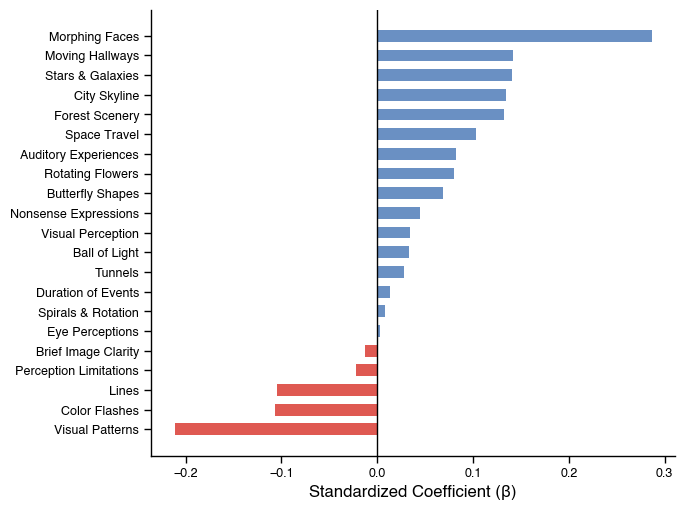

In [36]:
# Set Helvetica font
plt.rcParams['font.family'] = 'Helvetica'

# Get the non-zero coefficients
coefs = pd.Series(lasso_cv.coef_, index=X.columns)
nonzero_coefs = coefs[coefs != 0].sort_values(ascending=False)

# Apply label mapping for better readability
label_mapping = {
    "city_skyline": "City Skyline",
    "unpleasant_experience": "Unpleasant Experience",
    "morphing_faces": "Morphing Faces",
    "stars_galaxies": "Stars & Galaxies",
    "tunnels": "Tunnels",
    "moving_hallways": "Moving Hallways",
    "butterfly_shapes": "Butterfly Shapes",
    "auditory_experiences": "Auditory Experiences",
    "space_travel": "Space Travel",
    "indifference": "Indifference",
    "rotating_flowers": "Rotating Flowers",
    "spirals_and_rotation": "Spirals & Rotation",
    "geometric_shapes": "Geometric Shapes",
    "forest_scenery": "Forest Scenery",
    "spider_web_patterns": "Spider Web Patterns",
    "ocean_at_night": "Ocean at Night",
    "fractals": "Fractals",
    "perception_limitations": "Perception Limitations",
    "lines": "Lines",
    "color_flashes": "Color Flashes",
    "visual_patterns": "Visual Patterns",
    "visual_perception": "Visual Perception",
    "ball_of_light": "Ball of Light",
    "eye_perceptions": "Eye Perceptions",
    "brief_image_clarity": "Brief Image Clarity",
    "nonsense_expressions": "Nonsense Expressions",
    "event_duration": "Duration of Events"
}

# Map the index to pretty labels
nonzero_coefs.index = [label_mapping.get(x, x) for x in nonzero_coefs.index]

# Create the forest plot with paper-appropriate dimensions
fig, ax = plt.subplots(figsize=(7, len(nonzero_coefs) * 0.25))

# Get positions for y-axis
y_pos = np.arange(len(nonzero_coefs))

# Create horizontal bar plot with scientific paper colors
colors = ['#d73027' if x < 0 else '#4575b4' for x in nonzero_coefs.values]
bars = ax.barh(y_pos, nonzero_coefs.values, color=colors, alpha=0.8, height=0.6)

# Customize the plot with paper-appropriate font sizes
ax.set_yticks(y_pos)
ax.set_yticklabels(nonzero_coefs.index, fontsize=10)
ax.set_xlabel('Standardized Coefficient (β)', fontsize=12)
# ax.set_title('Lasso Regression Coefficients for Visual Vividness Prediction', 
#              fontsize=12, pad=15)

# Add vertical line at x=0
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Clean up the plot - remove gridlines and coefficient text
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Style tick labels
ax.tick_params(axis='x', labelsize=9)
ax.tick_params(axis='y', labelsize=9)

# Invert y-axis to have highest coefficient at top
ax.invert_yaxis()

plt.tight_layout()

# Save the plot in high resolution suitable for publication
plt.savefig('../plots//lasso_coefficients_forest_plot.png', 
           dpi=300, 
           bbox_inches='tight', 
           facecolor='white',
           edgecolor='none')

# Optionally save as PDF for vector graphics
plt.savefig('../plots//lasso_coefficients_forest_plot.pdf', 
           bbox_inches='tight', 
           facecolor='white',
           edgecolor='none')

plt.show()

In [37]:
def run_permutation_test(df, X, target_group, n_iter=1000, random_state=42):
    """
    Perform permutation test by shuffling labels and training Lasso classifiers multiple times.
    Returns list of F1 scores from null distribution.
    """
    rng = np.random.default_rng(random_state)
    null_f1_scores = []

    y_true = df['vividness_bin'].apply(lambda x: 1 if x == target_group else 0).values

    for i in range(n_iter):
        y_permuted = shuffle(y_true, random_state=random_state + i)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_permuted, stratify=y_permuted, test_size=0.2, random_state=random_state
        )

        model = LogisticRegressionCV(
            Cs=np.logspace(-2, 2, 30),
            penalty='l1',
            solver='saga',
            scoring='f1',
            cv=10,
            max_iter=10000,
            class_weight='balanced',
            random_state=random_state
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred)
        null_f1_scores.append(score)

    return null_f1_scores


# null_scores_strong = run_permutation_test(df, X, 'strong', n_iter=1000)



In [38]:
def run_permutation_test(df, X, target_group, n_iter=1000, random_state=42):
    """
    Perform permutation test by shuffling labels and training Lasso classifiers multiple times.
    Returns list of F1 scores from null distribution.
    """
    rng = np.random.default_rng(random_state)
    null_f1_scores = []

    y_true = df['vividness_bin'].apply(lambda x: 1 if x == target_group else 0).values

    for i in range(n_iter):
        y_permuted = shuffle(y_true, random_state=random_state + i)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_permuted, stratify=y_permuted, test_size=0.2, random_state=random_state
        )

        model = LogisticRegressionCV(
            Cs=np.logspace(-2, 2, 30),
            penalty='l1',
            solver='saga',
            scoring='f1',
            cv=10,
            max_iter=10000,
            class_weight='balanced',
            random_state=random_state
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred)
        null_f1_scores.append(score)

    return null_f1_scores


# null_scores_strong = run_permutation_test(df, X, 'strong', n_iter=1000)



In [39]:
null_scores_strong = run_permutation_test(df, X, 'strong', n_iter=1000)

In [40]:
actual_f1 = 0.44
null_scores = np.array(null_scores_strong)
p_value = np.mean(null_scores >= actual_f1)
print(f"P(Null ≥ Actual) = {p_value:.4f}")

P(Null ≥ Actual) = 0.0020


**Results**
To test whether classification performance exceeded chance, we conducted a permutation test by shuffling imagery group labels and retraining the model 500 times. The F1 score of the actual model (0.44) exceeded 99.8% of models trained on permuted labels (p = 0.002), confirming that the model identified above-chance structure in the data.

**Methods**
Null distributions were computed using permutation testing: for each of 500 iterations, imagery group labels were randomly shuffled while keeping feature values intact. A Lasso-regularized classifier was then trained and evaluated, and its F1 score recorded.


In [41]:
null_scores_weak = run_permutation_test(df, X, 'weak', n_iter=1000)

In [42]:
actual_f1_weak = 0.54
null_scores_weak = np.array(null_scores_weak)
p_value = np.mean(null_scores_weak >= actual_f1_weak)
print(f"P(Null ≥ Actual) = {p_value:.4f}")

P(Null ≥ Actual) = 0.0000


In [43]:
null_scores_moderate = run_permutation_test(df, X, 'moderate', n_iter=1000)

In [44]:
actual_f1_moderate = 0.43
null_scores_moderate = np.array(null_scores_moderate)
p_value = np.mean(null_scores_weak >= actual_f1_moderate)
print(f"P(Null ≥ Actual) = {p_value:.4f}")

P(Null ≥ Actual) = 0.5290


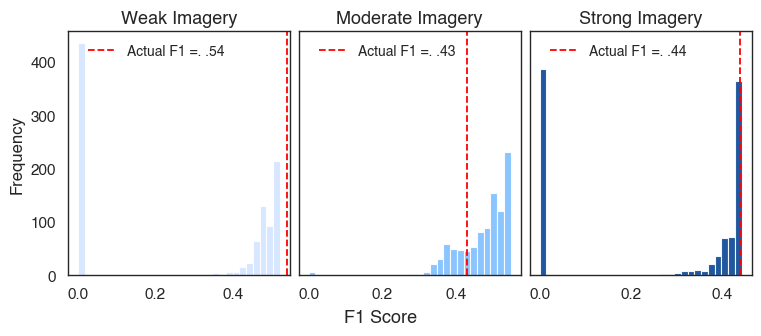

In [61]:
# ------------------------------------------------------------
# 0 · Global style
# ------------------------------------------------------------
sns.set_style("white")
plt.rcParams.update({
    "font.family": "Helvetica",
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
})

# ------------------------------------------------------------
# 1 · Color palette
# ------------------------------------------------------------
palette = {
    'weak':     '#d3e5ff',
    'moderate': '#7fbfff',
    'strong':   '#084594'
}

# ------------------------------------------------------------
# 2 · Data containers
# ------------------------------------------------------------
data = [
    dict(null_scores=null_scores_weak,     actual_f1=actual_f1_weak,
         title="Weak Imagery",  color=palette['weak']),
    dict(null_scores=null_scores_moderate, actual_f1=actual_f1_moderate,
         title="Moderate Imagery", color=palette['moderate']),
    dict(null_scores=null_scores,          actual_f1=actual_f1,
         title="Strong Imagery", color=palette['strong'])
]

# ------------------------------------------------------------
# 3 · Figure & subplots
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(7.5, 3), sharey=True,
                         constrained_layout=True)

for i, (ax, d) in enumerate(zip(axes, data)):
    ax.hist(d['null_scores'], bins=30, color=d['color'],
            edgecolor='white', alpha=0.9)

    ax.axvline(d['actual_f1'], color='red', linestyle='--',
               linewidth=1.3,
               label=f"Actual F1 =. {d['actual_f1']:.2f}".replace('0.', '.'))

    ax.set_title(d['title'], fontsize=13, fontweight='bold')
    if i == 0:
        ax.set_ylabel("Frequency", fontsize=12)

    ax.legend(frameon=False, loc='upper center',
              bbox_to_anchor=(0.4, 1))

# ------------------------------------------------------------
# 4 · Shared x-axis label (placed just above tick labels)
# ------------------------------------------------------------
fig.supxlabel("F1 Score", fontsize=13, y=-0.07)  # adjust y to fine-tune spacing

# ------------------------------------------------------------
# 5 · Save & show
# ------------------------------------------------------------
plt.savefig("../plots/null_distribution_f1_scores.png", dpi=300, bbox_inches="tight")
plt.savefig('../plots//null_distribution_f1_scores.pdf', 
           bbox_inches='tight', 
           facecolor='white',
           edgecolor='none')
plt.show()


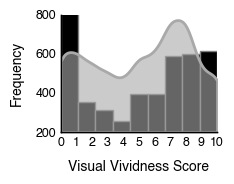

In [46]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 12  # Smaller font size for smaller plot

# Create a new figure with smaller dimensions
fig, ax = plt.subplots(figsize=(2.5, 2))

# Plot: Histogram and KDE with black bars, gray outline, and visible gray curve
sns.histplot(data=df, x='visual_vividness', bins=9, color='black', alpha=1, 
             edgecolor='gray', linewidth=1, ax=ax)

kde_ax = ax.twinx()
sns.kdeplot(data=df, x='visual_vividness', color='darkgray', fill=True, 
            alpha=0.6, linewidth=2, ax=kde_ax, cut=0)  # Thinner line for smaller plot

kde_ax.set_yticks([])  # Hide y-axis labels and ticks for KDE plot
kde_ax.set_ylabel('')

# Set labels and limits with smaller font sizes
ax.set_xlabel('Visual Vividness Score', fontsize=10, labelpad=8)
ax.set_ylabel('Frequency', fontsize=10, labelpad=8)
ax.set_xlim(0, 10)
ax.set_ylim(200, 800)
ax.set_xticks(range(11))

# Adjust tick parameters for smaller plot
ax.tick_params(axis='both', which='both', length=0, labelsize=9)

# Adjust layout
plt.tight_layout()
sns.despine()  # Remove the top and right spines

# Create plots_paper directory if it doesn't exist
import os
os.makedirs('plots_paper', exist_ok=True)

# Save the figure to plots_paper folder
plt.savefig('../plots//visual_vividness_histogram_kde.png', dpi=300, bbox_inches='tight')
plt.savefig('../plots//visual_vividness_histogram_kde.pdf', 
           bbox_inches='tight', 
           facecolor='white',
           edgecolor='none')

# Show the plot
plt.show()